### Import Library

In [12]:
import os
import time
import copy
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # biar lebih tahan file "agak rusak"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from torch.cuda.amp import autocast, GradScaler

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


### Config, Path, Device

In [13]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_ROOT = "/kaggle/input/dogs-and-cats-dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test1")
SAMPLE_SUB = os.path.join(DATA_ROOT, "sampleSubmission.csv")

print("DATA_ROOT exists:", os.path.exists(DATA_ROOT))
print("train exists:", os.path.exists(TRAIN_DIR))
print("test1 exists:", os.path.exists(TEST_DIR))
print("sampleSubmission exists:", os.path.exists(SAMPLE_SUB))

print("Train example:", sorted(os.listdir(TRAIN_DIR))[:5])
print("Test example :", sorted(os.listdir(TEST_DIR))[:5])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


DATA_ROOT exists: True
train exists: True
test1 exists: True
sampleSubmission exists: True
Train example: ['train']
Test example : ['test1']
Device: cuda


### Auto Detect

In [14]:

IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp",".ppm",".pgm")

def auto_pick_train_dir(data_root: str):
    candidates = []
    for d, _, files in os.walk(data_root):
        n_img = sum(1 for f in files if f.lower().endswith(IMG_EXTS))
        if n_img > 0:
            score = n_img + (1_000_000 if "train" in d.lower() else 0)  # prioritas folder yang ada kata "train"
            candidates.append((score, n_img, d))

    candidates.sort(reverse=True)
    if not candidates:
        raise RuntimeError("Tidak menemukan folder yang berisi gambar di DATA_ROOT.")

    best = candidates[0][2]
    top5 = [(n, p) for _, n, p in candidates[:5]]
    return best, top5

best_train_dir, top5 = auto_pick_train_dir(DATA_ROOT)
print("Top-5 image folders (count, path):")
for n, p in top5:
    print(n, "->", p)

TRAIN_DIR = best_train_dir
print("\nAUTO TRAIN_DIR =", TRAIN_DIR)
print("Example files:", sorted(os.listdir(TRAIN_DIR))[:10])


Top-5 image folders (count, path):
25000 -> /kaggle/input/dogs-and-cats-dataset/train/train
12500 -> /kaggle/input/dogs-and-cats-dataset/test1/test1

AUTO TRAIN_DIR = /kaggle/input/dogs-and-cats-dataset/train/train
Example files: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg']


### Index Train

In [15]:
def build_train_samples(train_dir):
    train_dir = Path(train_dir)

    files = [p for p in train_dir.rglob("*") if p.is_file() and p.suffix.lower() in set(IMG_EXTS)]
    print("Total image files found:", len(files))

    samples = []
    for p in files:
        name = p.name.lower()
        parent = p.parent.name.lower()

        # pola filename (dog.xxx.jpg / cat.xxx.jpg)
        if name.startswith("dog"):
            y = 1
        elif name.startswith("cat"):
            y = 0
        # pola folder (train/dog/xxx.jpg, train/cat/xxx.jpg)
        elif "dog" in parent:
            y = 1
        elif "cat" in parent:
            y = 0
        else:
            continue

        samples.append((str(p), y))

    print("Matched labeled samples:", len(samples))
    if len(samples) > 0:
        ys = [y for _, y in samples]
        print("Dogs:", sum(ys), "| Cats:", len(ys) - sum(ys))
        print("Example matched:", [Path(samples[i][0]).name for i in range(min(5, len(samples)))])
    else:
        print("WARNING: 0 samples terlabel. Biasanya karena nama file/folder tidak mengandung 'cat'/'dog'.")

    return samples

all_samples = build_train_samples(TRAIN_DIR)

assert len(all_samples) > 0, "all_samples masih 0. TRAIN_DIR salah atau pola nama file/folder tidak sesuai."


Total image files found: 25000
Matched labeled samples: 25000
Dogs: 12500 | Cats: 12500
Example matched: ['cat.12461.jpg', 'dog.3443.jpg', 'dog.7971.jpg', 'dog.10728.jpg', 'dog.1942.jpg']


### Stratified Split

In [16]:
def stratified_split(samples, train_ratio=0.8, seed=42):
    rng = np.random.default_rng(seed)

    by_class = defaultdict(list)
    for i, (_, y) in enumerate(samples):
        by_class[y].append(i)

    train_idx, val_idx = [], []
    for y, idxs in by_class.items():
        idxs = np.array(idxs)
        rng.shuffle(idxs)
        n_train = int(len(idxs) * train_ratio)

        train_idx.extend(idxs[:n_train].tolist())
        val_idx.extend(idxs[n_train:].tolist())

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    train_samples = [samples[i] for i in train_idx]
    val_samples   = [samples[i] for i in val_idx]
    return train_samples, val_samples

train_samples, val_samples = stratified_split(all_samples, train_ratio=0.8, seed=SEED)
print("Train:", len(train_samples), "Val:", len(val_samples))
assert len(train_samples) > 0 and len(val_samples) > 0


Train: 20000 Val: 5000


### Transforms

In [17]:
IMG_SIZE = 224

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])


### Dataset Class

In [18]:
class DogsCatsTrainDataset(Dataset):
    def __init__(self, samples, transform=None, safe_load=False, max_retries=10):
        self.samples = samples
        self.transform = transform
        self.safe_load = safe_load
        self.max_retries = max_retries

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tries = 0
        while True:
            path, y = self.samples[idx]
            try:
                with Image.open(path) as img:
                    img = img.convert("RGB")
                if self.transform:
                    img = self.transform(img)
                # BCEWithLogitsLoss butuh float label
                return img, torch.tensor(y, dtype=torch.float32)
            except Exception:
                if not self.safe_load:
                    raise
                tries += 1
                if tries >= self.max_retries:
                    raise RuntimeError(f"Terlalu banyak file corrupt. Last: {path}")
                idx = random.randrange(0, len(self.samples))

class DogsCatsTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.files = sorted([p for p in Path(test_dir).iterdir() if p.suffix.lower() == ".jpg"])
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        p = self.files[idx]
        with Image.open(p) as img:
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        img_id = int(p.stem)  # "1234.jpg" -> 1234
        return img, img_id

train_ds = DogsCatsTrainDataset(train_samples, transform=train_tf, safe_load=True)
val_ds   = DogsCatsTrainDataset(val_samples,   transform=eval_tf,  safe_load=False)

print("len(train_ds) =", len(train_ds))
print("len(val_ds)   =", len(val_ds))

assert len(train_ds) > 0, "train_ds kosong. Cek Cell 3/4 (indexing & split)."
assert len(val_ds) > 0, "val_ds kosong. Cek Cell 3/4 (indexing & split)."



len(train_ds) = 20000
len(val_ds)   = 5000


### DataLoader Tuning

In [19]:
batch_size = 64  # kalau belum ada, set di sini

pin = (device.type == "cuda")
num_workers = max(2, (os.cpu_count() or 4) - 1)

persistent = True if num_workers > 0 else False
prefetch = 4 if num_workers > 0 else None

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=pin,
    persistent_workers=persistent,
    prefetch_factor=prefetch,
    drop_last=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin,
    persistent_workers=persistent,
    prefetch_factor=prefetch
)

print("workers:", num_workers, "| pin:", pin, "| persistent:", persistent, "| prefetch:", prefetch)
print("train batches:", len(train_loader), "| val batches:", len(val_loader))

workers: 3 | pin: True | persistent: True | prefetch: 4
train batches: 312 | val batches: 79


### Build Model ResNet50 (pretrained) + Loss/Opt/Scheduler + AMP

In [20]:
def build_resnet50(pretrained=True):
    weights = models.ResNet50_Weights.DEFAULT if pretrained else None
    model = models.resnet50(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 1)  # binary logits (1 output)
    return model

model = build_resnet50(pretrained=True).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
EPOCHS = 8
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = GradScaler(enabled=(device.type == "cuda"))
print(model.__class__.__name__)


ResNet


/tmp/ipykernel_55/3105468586.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


### Train/Val Loop + Best Checkpoint + Early Stopping

In [21]:
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def train_one_epoch():
    model.train()
    loss_sum, correct, n = 0.0, 0, 0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).unsqueeze(1)  # (B,1)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)                 # (B,1)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = x.size(0)
        loss_sum += loss.item() * bs
        n += bs

        probs = torch.sigmoid(logits).detach()
        preds = (probs >= 0.5).float()
        correct += (preds == y).sum().item()

    return loss_sum / n, correct / n

@torch.no_grad()
def validate_collect():
    model.eval()
    loss_sum, n = 0.0, 0
    y_true, y_prob = [], []

    for x, y in val_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).unsqueeze(1)

        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        bs = x.size(0)
        loss_sum += loss.item() * bs
        n += bs

        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        y_prob.append(probs)
        y_true.append(y.squeeze(1).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_prob = np.concatenate(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)

    val_acc = (y_pred == y_true).mean()
    return loss_sum / n, val_acc, y_true, y_pred, y_prob

best_val_acc = 0.0
best_wts = None
patience = 3
bad = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch()
    val_loss, val_acc, _, _, _ = validate_collect()
    scheduler.step()

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {ep}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} | {time.time()-t0:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_wts = copy.deepcopy(model.state_dict())
        bad = 0
        torch.save(best_wts, "resnet50_best.pth")
        print("  ✓ Saved best -> resnet50_best.pth")
    else:
        bad += 1
        if bad >= patience:
            print("  Early stopping (val acc tidak naik)")
            break

# load best
if best_wts is not None:
    model.load_state_dict(best_wts)


/tmp/ipykernel_55/1206787618.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
/tmp/ipykernel_55/1206787618.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Epoch 1/8 | train_loss=0.0581 train_acc=0.9853 | val_loss=0.0220 val_acc=0.9936 | 168.8s
  ✓ Saved best -> resnet50_best.pth
Epoch 2/8 | train_loss=0.0185 train_acc=0.9943 | val_loss=0.0222 val_acc=0.9910 | 124.7s
Epoch 3/8 | train_loss=0.0115 train_acc=0.9964 | val_loss=0.0264 val_acc=0.9906 | 125.7s
Epoch 4/8 | train_loss=0.0068 train_acc=0.9977 | val_loss=0.0227 val_acc=0.9926 | 124.2s
  ✋ Early stopping (val acc tidak naik)


### Plot Curve

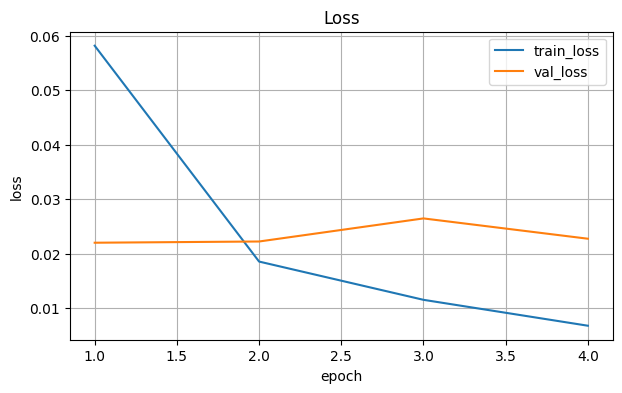

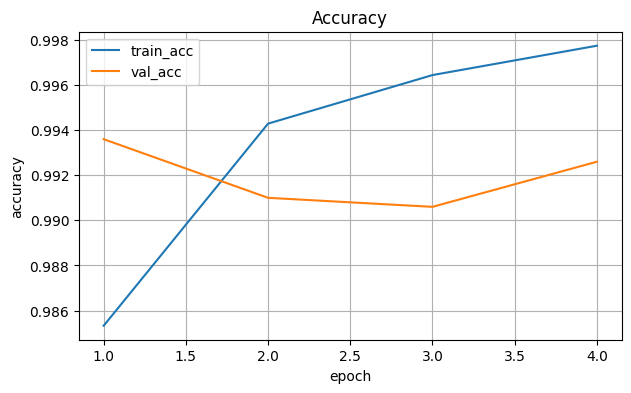

In [22]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["val_acc"], label="val_acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy")
plt.legend(); plt.grid(True); plt.show()


### Confusion Matrix + ROC-AUC

/tmp/ipykernel_55/1206787618.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


VAL ACC: 0.9936
              precision    recall  f1-score   support

      cat(0)       0.99      1.00      0.99      2500
      dog(1)       1.00      0.99      0.99      2500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



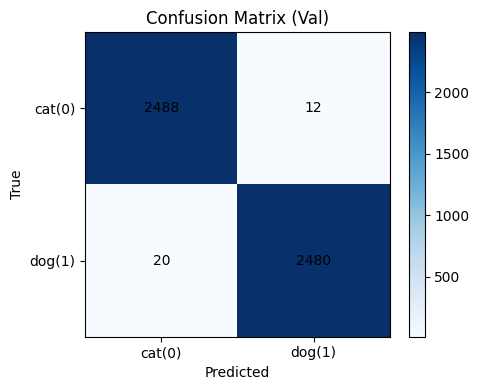

ROC-AUC (Val): 0.9998


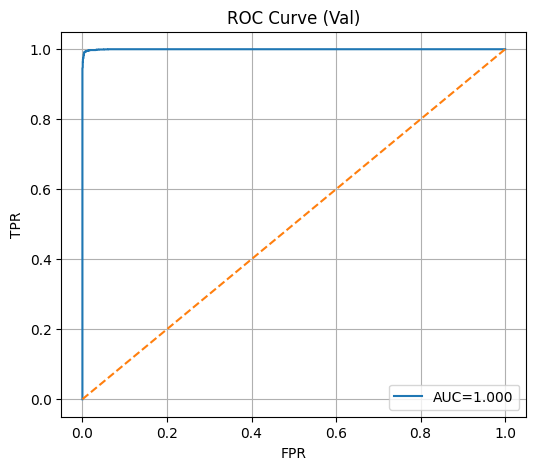

In [23]:
val_loss, val_acc, y_true, y_pred, y_prob = validate_collect()

print("VAL ACC:", round(float(val_acc), 4))
print(classification_report(y_true, y_pred, target_names=["cat(0)", "dog(1)"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Val)")
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xticks([0,1], ["cat(0)","dog(1)"])
plt.yticks([0,1], ["cat(0)","dog(1)"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC-AUC (binary)
auc_score = roc_auc_score(y_true, y_prob)
print("ROC-AUC (Val):", round(float(auc_score), 4))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve (Val)")
plt.legend(); plt.grid(True); plt.show()
